/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


0.999381752377


[]

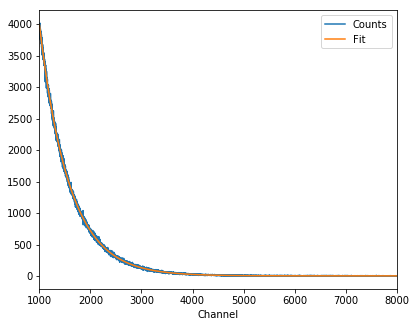

In [10]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

MIN_RANGE=1000
MAX_RANGE=8000

def exp_fit(x, a, b, c):
    return a*np.exp(-b*x) + c

def calc_rsquared(residuals, xdata, ydata):
    ss_res = residuals.apply(lambda res: res**2).sum()
    ss_tot = (ydata-ydata.mean()).apply(lambda diff: diff**2).sum()

    r_squared = 1 - (ss_res / ss_tot)   
    
    return r_squared

data = pandas.read_csv('data/lifetime.csv')

actual_data = data.loc[(data['Channel'] >= MIN_RANGE) & (data['Channel'] <= MAX_RANGE), ['Channel', 'Counts']]
popt, pcov = curve_fit(exp_fit, actual_data['Channel'], actual_data['Counts'], p0=[1, 1e-3, 1])

actual_data['Fit'] = actual_data['Channel'].apply(lambda chan: exp_fit(chan, popt[0], popt[1], popt[2]))
actual_data['Residuals'] = actual_data['Counts'] - actual_data['Fit']

print calc_rsquared(actual_data['Residuals'], actual_data['Channel'], actual_data['Counts'])

fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')

actual_data.plot(
    x='Channel',
    y='Counts',
    ax=ax
)

actual_data.plot(
    x='Channel',
    y='Fit',
    ax=ax
)
fig.set_size_inches(6.40, 5.12)
plt.plot()